# Import Libraries

In [57]:
import pathlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Import Dataset

In [40]:
# Create a directory for the Kaggle file
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the Kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions to read and write
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d roobansappani/hand-gesture-recognition

Dataset URL: https://www.kaggle.com/datasets/roobansappani/hand-gesture-recognition
License(s): copyright-authors
 63% 17.0M/27.1M [00:00<00:00, 35.7MB/s]
100% 27.1M/27.1M [00:00<00:00, 55.4MB/s]


In [4]:
!unzip hand-gesture-recognition

Streaming output truncated to the last 5000 lines.
  inflating: HandGesture/images/call_me/3992.jpg  
  inflating: HandGesture/images/call_me/3999.jpg  
  inflating: HandGesture/images/call_me/4006.jpg  
  inflating: HandGesture/images/call_me/4012.jpg  
  inflating: HandGesture/images/call_me/4020.jpg  
  inflating: HandGesture/images/call_me/4028.jpg  
  inflating: HandGesture/images/call_me/4035.jpg  
  inflating: HandGesture/images/call_me/4043.jpg  
  inflating: HandGesture/images/call_me/4049.jpg  
  inflating: HandGesture/images/call_me/4057.jpg  
  inflating: HandGesture/images/call_me/4066.jpg  
  inflating: HandGesture/images/call_me/411.jpg  
  inflating: HandGesture/images/call_me/425.jpg  
  inflating: HandGesture/images/call_me/4327.jpg  
  inflating: HandGesture/images/call_me/4335.jpg  
  inflating: HandGesture/images/call_me/4341.jpg  
  inflating: HandGesture/images/call_me/4348.jpg  
  inflating: HandGesture/images/call_me/4355.jpg  
  inflating: HandGesture/images/c

# 1. Load and Prepare Data

In [41]:
# Define the path to the images directory
data_path = pathlib.Path(r'/content/HandGesture/images')

# Get all image file paths with '.jpg' extension recursively from the directory
img_path = list(data_path.glob('**/*.jpg'))

# Extract labels from the file paths
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [42]:
# Create a pandas Series for image paths
pd_img_path = pd.Series(img_path, name='PATH').astype(str)

# Create a pandas Series for image labels
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

# Combine image paths and labels into a single DataFrame
img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

# Shuffle the dataframe
img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head(5243)

,PATH,LABELS
0,/content/HandGesture/images/rock/491.jpg,rock
1,/content/HandGesture/images/okay/1373.jpg,okay
2,/content/HandGesture/images/fingers_crossed/68...,fingers_crossed
3,/content/HandGesture/images/peace/481.jpg,peace
4,/content/HandGesture/images/okay/2640.jpg,okay
...,...,...
5238,/content/HandGesture/images/scissor/1692.jpg,scissor
5239,/content/HandGesture/images/peace/1934.jpg,peace
5240,/content/HandGesture/images/rock/702.jpg,rock
5241,/content/HandGesture/images/thumbs/4341.jpg,thumbs


In [43]:
# Count the unique classes and number of images in them
img_df['LABELS'].value_counts(ascending=True)

,count
LABELS,
fingers_crossed,504
up,504
rock,508
peace,526
call_me,527
scissor,527
rock_on,531
thumbs,537
paper,539


# 2: Data Preprocessing and Augmentation

In [44]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 train-validation split
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 3: Create Training and Validation Generators

In [45]:
train_gen = datagen.flow_from_dataframe(
    img_df,
    directory=None,
    x_col='PATH',
    y_col='LABELS',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    img_df,
    directory=None,
    x_col='PATH',
    y_col='LABELS',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4195 validated image filenames belonging to 10 classes.
Found 1048 validated image filenames belonging to 10 classes.


# 4: Define the CNN Model

In [46]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 output classes
])

# 5. Compile the model

In [47]:
# Step 5: Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Train the model

In [48]:
# Step 6: Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25
)

Epoch 1/25
132/132 [==============================] - 26s 189ms/step - loss: 2.0260 - accuracy: 0.2484 - val_loss: 1.4426 - val_accuracy: 0.4895
Epoch 2/25
132/132 [==============================] - 24s 185ms/step - loss: 1.4185 - accuracy: 0.4875 - val_loss: 1.0324 - val_accuracy: 0.6651
Epoch 3/25
132/132 [==============================] - 25s 187ms/step - loss: 1.1752 - accuracy: 0.5814 - val_loss: 0.9786 - val_accuracy: 0.6803
Epoch 4/25
132/132 [==============================] - 25s 185ms/step - loss: 1.0307 - accuracy: 0.6334 - val_loss: 0.7804 - val_accuracy: 0.7595
Epoch 5/25
132/132 [==============================] - 25s 188ms/step - loss: 0.9114 - accuracy: 0.6810 - val_loss: 0.6444 - val_accuracy: 0.7901
Epoch 6/25
132/132 [==============================] - 25s 188ms/step - loss: 0.8830 - accuracy: 0.6903 - val_loss: 0.6801 - val_accuracy: 0.7672
Epoch 7/25
132/132 [==============================] - 25s 189ms/step - loss: 0.8390 - accuracy: 0.7170 - val_loss: 0.5705 - val_ac

# 7. Evaluate the model

In [49]:
# Step 7: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

33/33 [==============================] - 4s 129ms/step - loss: 0.2263 - accuracy: 0.9313
Validation Loss: 0.22626078128814697
Validation Accuracy: 0.9312977194786072


# 8. Save the Model

In [50]:
# Step 8: Save the Model
model.save('hand_gesture_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing the model

In [51]:
# Prepare Image for Prediction
def prepare_image(img_path):
    img = load_img(img_path, target_size=(128, 128))  # Use load_img from tensorflow.keras.utils
    img_array = img_to_array(img) # Use img_to_array from tensorflow.keras.utils
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def get_actual_class(img_path):
    # Extract the actual class from the image path
    return os.path.split(os.path.split(img_path)[0])[1]

# Predict Hand Gesture
def predict_hand_gesture(img_path, model):
    img_array = prepare_image(img_path)
    prediction = model.predict(img_array)

    # Get the index of the highest probability
    predicted_class_index = np.argmax(prediction[0])

    # Retrieve class labels from the training generator
    class_labels = list(train_gen.class_indices.keys())
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, prediction[0][predicted_class_index]


In [52]:
# Example usage:
img_path = '/content/HandGesture/images/rock/1023.jpg'

actual_class = get_actual_class(img_path)
predicted_class, confidence = predict_hand_gesture(img_path, model)

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

img_path2 = '/content/HandGesture/images/paper/1031.jpg'

actual_class2 = get_actual_class(img_path2)
predicted_class2, confidence2 = predict_hand_gesture(img_path2, model)

print(f"Actual Class: {actual_class2}")
print(f"Predicted Class: {predicted_class2}, Confidence: {confidence2:.2f}")

img_path3 = '/content/HandGesture/images/fingers_crossed/1444.jpg'

actual_class3 = get_actual_class(img_path3)
predicted_class3, confidence3 = predict_hand_gesture(img_path3, model)

print(f"Actual Class: {actual_class3}")
print(f"Predicted Class: {predicted_class3}, Confidence: {confidence3:.2f}")

1/1 [==============================] - 0s 76ms/step
Actual Class: rock
Predicted Class: rock, Confidence: 1.00
1/1 [==============================] - 0s 27ms/step
Actual Class: paper
Predicted Class: paper, Confidence: 1.00
1/1 [==============================] - 0s 27ms/step
Actual Class: fingers_crossed
Predicted Class: fingers_crossed, Confidence: 0.96


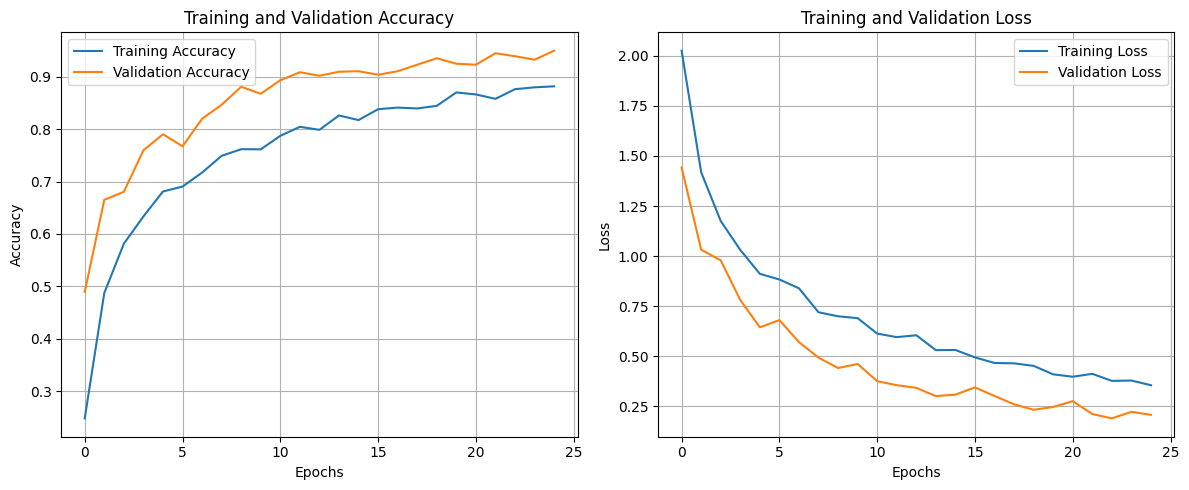

In [53]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

33/33 [==============================] - 4s 127ms/step


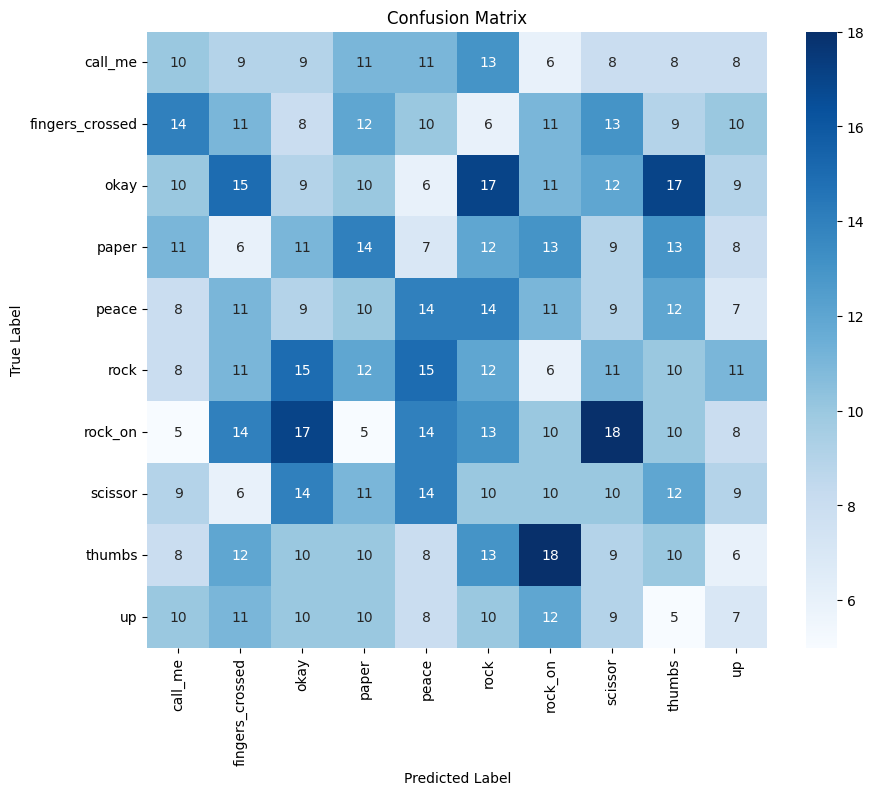

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Step 1: Generate predictions on the test set
predictions = model.predict(val_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get true labels from the test set
true_classes = val_gen.classes  # These are the actual labels from the test set
class_labels = list(val_gen.class_indices.keys())  # List of class labels

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()